# LaBraM — PhysioNet EEGMMIDB fine-tuning (ALL runs → Left vs Right)

Goal: fine-tune a pretrained LaBraM checkpoint on PhysioNet EEGMMIDB using **just real runs**  
(runs 3, 7, 11 = real), predict **Left vs Right**.

In [1]:
import os, sys, random
from pathlib import Path
import numpy as np
import torch

PROJECT_ROOT = Path.cwd()
LABRAM_ROOT = PROJECT_ROOT / "LaBraM"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("LABRAM_ROOT:", LABRAM_ROOT, "exists?", LABRAM_ROOT.exists())

# Make LaBraM importable
if str(LABRAM_ROOT) not in sys.path:
    sys.path.insert(0, str(LABRAM_ROOT))

# Reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("torch:", torch.__version__)

PROJECT_ROOT: /home/jovyan/projects/neuro-eeg
LABRAM_ROOT: /home/jovyan/projects/neuro-eeg/LaBraM exists? True
Device: cuda
torch: 2.8.0+cu128


## Data location

We use the PhysioNet EEGMMIDB dataset from the repo's `data/` folder.

Expected root:
`data/physionet.org/files/eegmmidb/1.0.0`

In [2]:
DATA_ROOT = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"
print("DATA_ROOT:", DATA_ROOT)
print("Exists?", DATA_ROOT.exists())

# Optional: list first few subject dirs
if DATA_ROOT.exists():
    subdirs = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir() and p.name.startswith("S")])
    print("Num subject folders found:", len(subdirs))
    print("First 5 subject folders:", subdirs[:5])

DATA_ROOT: /home/jovyan/projects/neuro-eeg/data/physionet.org/files/eegmmidb/1.0.0
Exists? True
Num subject folders found: 109
First 5 subject folders: ['S001', 'S002', 'S003', 'S004', 'S005']


## Dataloader for  runs (3,7,11) → Left vs Right

The dataloader:
- reads EDF with MNE
- selects the BCI-style 22 channels
- preprocesses + resamples to 200 Hz
- extracts 4-second segments
- returns tensors shaped **(22, 4, 200)** for LaBraM

## Imports: LaBraM model registration + new ALL-runs dataloader

- `modeling_finetune` registers the LaBraM models into `timm`
- `EEGMMIDBLaBraMAllRunsLRDataset` loads PhysioNet EEGMMIDB runs 3,4,7,8 and labels only Left/Right

In [15]:
import timm

# Important: this import registers the model names into timm
import modeling_finetune  # from LaBraM/

from dataloader.eegmmidb_labram_dataset_allruns_2class import (
    EEGMMIDBLaBraMAllRunsLRDataset,
    PreprocConfig,
    BCI22_CHANNELS,
    LABRAM_64_MAP,
)

print("LaBraM model registered?", "labram_base_patch200_200" in timm.list_models())
print("Num timm models:", len(timm.list_models()))

LaBraM model registered? True
Num timm models: 615


## Dataset: PhysioNet EEGMMIDB (All motor runs → Left vs Right)

We load **all left/right motor-related runs** from the PhysioNet EEGMMIDB dataset and **collapse imagined and real movements into a single binary task** (Left vs Right).

### Runs used

According to the official EEGMMIDB protocol:

- **Real (executed) left / right hand**
  - Runs **3, 7, 11**

- **Imagined left / right hand**
  - Runs **4, 8, 12**

In this notebook, we use runs:

- **3, 7, 11** → left/right hand motor tasks  
  (only *real*)

### Label mapping

- **0 = Left hand** (T1)
- **1 = Right hand** (T2)

### Notes

- Imagined vs real movement is **intentionally ignored** at this stage.
- The model is trained to predict **hand laterality only (Left vs Right)**.
- Task type (*imagined* vs *real*) is retained in metadata and used **only for post-hoc analysis**, not for training.

In [4]:
from pathlib import Path
import torch

PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"

ds = EEGMMIDBLaBraMAllRunsLRDataset(
    root_path=str(DATA_ROOT),
    subjects=None,          # all subjects
    runs=[3, 7, 11],       # imagined + real, left/right
    t_min=0.0,
    t_max=4.0,              # 4 seconds → 800 samples @ 200 Hz
    normalization=True,
    is_train=True,
    add_noise_std=0.0,
    preproc=PreprocConfig(
        target_sfreq=200.0,
        notch_hz=50.0,
        l_freq=0.1,
        h_freq=75.0,
        reref="average",
        to_microvolts=True,
    ),
)

print("Dataset length:", len(ds))

sample = ds[0]
x = sample["inputs"]
y = sample["labels"]
meta = sample["meta"]

print("x shape:", x.shape)        # (22, 800)
print("label:", y)
print("label_name:", meta["label_name"])
print("run:", meta["run"])
print("task_type:", meta["task_type"])

/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Dataset length: 4927
x shape: torch.Size([22, 4, 200])
label: tensor(1)
label_name: T2
run: 3
task_type: real


In [5]:
import numpy as np
from collections import Counter

runs = [m["run"] for m in ds.metas]
tasks = [m["task_type"] for m in ds.metas]
labels = [int(y) for y in ds.labels]
label_names = [m["label_name"] for m in ds.metas]

print("Total samples:", len(ds))
print("Runs present:", sorted(set(runs)))
print("Run counts:", dict(sorted(Counter(runs).items())))

print("\nTask types present:", sorted(set(tasks)))
print("Task type counts:", dict(sorted(Counter(tasks).items())))

print("\nLabel ids present:", sorted(set(labels)))
print("Label counts:", dict(sorted(Counter(labels).items())))

print("\nLabel_name counts:", dict(sorted(Counter(label_names).items())))

# sanity: do we have both imagined and real, and all 4 runs?
expected_runs = {3, 7, 11}
print("\nMissing runs:", sorted(expected_runs - set(runs)))

Total samples: 4927
Runs present: [3, 7, 11]
Run counts: {3: 1647, 7: 1640, 11: 1640}

Task types present: ['real']
Task type counts: {'real': 4927}

Label ids present: [0, 1]
Label counts: {0: 2471, 1: 2456}

Label_name counts: {'T1': 2471, 'T2': 2456}

Missing runs: [4, 8, 12]


## Ensure reproducibility

In [6]:
# --- Reproducibility guard (run BEFORE dataset split / dataloaders) ---
import os, random
import numpy as np
import torch

SEED = 5  # change if you want a different run, but keep fixed for debugging
print("Using SEED =", SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# CUDNN controls (determinism vs speed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# For PyTorch >= 2.0 (more deterministic, may throw if an op has no deterministic impl)
try:
    torch.use_deterministic_algorithms(False)  # set True if you want strict determinism (can error)
except Exception as e:
    print("torch.use_deterministic_algorithms not available:", e)

print("torch initial seed:", torch.initial_seed())

Using SEED = 5
torch initial seed: 5


## Train/Val/Test split: split by SUBJECT

We must split by **subject**, not by individual windows, otherwise we leak person-specific patterns
into validation/test and inflate accuracy.

So we will:
- pick a set of subjects for train / val / test
- build **three datasets** (same preprocessing, different subject lists)

In [7]:
from dataloader.eegmmidb_labram_dataset_allruns import EEGMMIDBLaBraMAllRunsLRDataset, PreprocConfig
import numpy as np

# --- discover all subjects from the dataset we already loaded
all_subjects = sorted({m["subject"] for m in ds.metas})
print("Num subjects found:", len(all_subjects))
print("First 10 subjects:", all_subjects[:10])

# --- subject-wise split (80/10/10)
rng = np.random.default_rng(SEED)
perm = rng.permutation(all_subjects)

n = len(perm)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_subjects = sorted(perm[:n_train].tolist())
val_subjects = sorted(perm[n_train:n_train + n_val].tolist())
test_subjects = sorted(perm[n_train + n_val:].tolist())

print("\nSplit sizes:")
print("train subjects:", len(train_subjects))
print("val subjects:  ", len(val_subjects))
print("test subjects: ", len(test_subjects))

# --- reuse the same preprocessing config and run list
preproc = PreprocConfig(
    target_sfreq=200.0,
    notch_hz=50.0,
    l_freq=0.1,
    h_freq=75.0,
    reref="average",
    to_microvolts=True,
)

train_ds = EEGMMIDBLaBraMAllRunsLRDataset(
    root_path=str(DATA_ROOT),
    subjects=train_subjects,
    runs=[3, 7, 11],
    t_min=0.0, t_max=4.0,
    normalization=True,
    is_train=True,
    add_noise_std=0.02,   # mild noise aug like before
    preproc=preproc,
)

val_ds = EEGMMIDBLaBraMAllRunsLRDataset(
    root_path=str(DATA_ROOT),
    subjects=val_subjects,
    runs=[3, 7, 11],
    t_min=0.0, t_max=4.0,
    normalization=True,
    is_train=False,
    add_noise_std=0.0,
    preproc=preproc,
)

test_ds = EEGMMIDBLaBraMAllRunsLRDataset(
    root_path=str(DATA_ROOT),
    subjects=test_subjects,
    runs=[3, 7, 11],
    t_min=0.0, t_max=4.0,
    normalization=True,
    is_train=False,
    add_noise_std=0.0,
    preproc=preproc,
)

print("\nDataset lengths:")
print("train:", len(train_ds))
print("val:  ", len(val_ds))
print("test: ", len(test_ds))

Num subjects found: 109
First 10 subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Split sizes:
train subjects: 87
val subjects:   10
test subjects:  12


/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/home/jovyan/projects/neuro-eeg/dataloader/eegmmidb_labram_dataset_allruns.py:184: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)



Dataset lengths:
train: 3946
val:   441
test:  540


In [8]:
import warnings
from torch.utils.data import DataLoader

# Keep notebook output readable
warnings.filterwarnings("ignore", message="NOTE: pick_channels\\(\\) is a legacy function.*")
warnings.filterwarnings("ignore", message="Limited .* annotation\\(s\\).*expanding outside the data range.*")

BATCH_SIZE = 32
NUM_WORKERS = 6  # adjust if your JupyterHub is tight

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# quick sanity batch
batch = next(iter(train_loader))
print("Batch inputs:", tuple(batch["inputs"].shape), "Batch labels:", tuple(batch["labels"].shape))
print("Label min/max:", int(batch["labels"].min()), int(batch["labels"].max()))

meta = batch["meta"]

print("meta type:", type(meta))
print("meta keys:", list(meta.keys()))

# show one meta field (first 5 entries)
any_key = list(meta.keys())[0]
print(f"\nExample meta field '{any_key}' (first 5):", meta[any_key][:5])

Batch inputs: (32, 22, 4, 200) Batch labels: (32,)
Label min/max: 0 1
meta type: <class 'dict'>
meta keys: ['subject', 'run', 'task_type', 'label_name', 'sfreq', 'ch_names', 't_min', 't_max', 'path']

Example meta field 'subject' (first 5): tensor([84, 85, 67,  7, 67])


## LaBraM channel mapping (22 channels → LaBraM positional indices)

LaBraM was trained with a channel-position embedding table, so we pass an `input_chans` index list.

Key detail:
- LaBraM expects `input_chans` to include a dummy **0** index at the front (for the CLS token position usage in their code).
- Then we add the 22 mapped channel indices (from `LABRAM_64_MAP`).

So `input_chans` will have length **23**:
`[0] + [mapped indices for the 22 BCI channels]`

In [9]:
import sys
from pathlib import Path
from collections import OrderedDict
import torch
import timm

# --- Ensure LaBraM is importable + registers models
PROJECT_ROOT = Path.cwd()
LABRAM_ROOT = PROJECT_ROOT / "LaBraM"
if str(LABRAM_ROOT) not in sys.path:
    sys.path.insert(0, str(LABRAM_ROOT))

import modeling_finetune  # registers into timm

# --- input_chans: [0] + 22 mapped indices
mapped = [LABRAM_64_MAP[ch] for ch in BCI22_CHANNELS]
input_chans = torch.tensor([0] + mapped, dtype=torch.long)  # (23,)
print("input_chans shape:", tuple(input_chans.shape), "first 10:", input_chans[:10].tolist())

# --- Build LaBraM model for binary classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(
    "labram_base_patch200_200",
    pretrained=False,
    num_classes=2,
    drop_rate=0.0,
    drop_path_rate=0.1,
    attn_drop_rate=0.0,
    drop_block_rate=None,
    use_mean_pooling=True,
    init_scale=0.001,
    use_rel_pos_bias=True,
    use_abs_pos_emb=True,
    init_values=0.1,
    qkv_bias=True,
).to(device)

# --- Load pretrained checkpoint (labram-base.pth)
ckpt_path = PROJECT_ROOT / "LaBraM" / "checkpoints" / "labram-base.pth"
print("Loading checkpoint:", ckpt_path)

checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

checkpoint_model = checkpoint.get("model", checkpoint)

# Strip 'student.' prefix if present
if isinstance(checkpoint_model, dict) and any(k.startswith("student.") for k in checkpoint_model.keys()):
    new_dict = OrderedDict()
    for k, v in checkpoint_model.items():
        if k.startswith("student."):
            new_dict[k[len("student."):]] = v
    checkpoint_model = new_dict
    print("Stripped 'student.' prefix.")

# Remove classifier head if mismatched
state_dict = model.state_dict()
for k in ["head.weight", "head.bias"]:
    if k in checkpoint_model and k in state_dict and checkpoint_model[k].shape != state_dict[k].shape:
        del checkpoint_model[k]

# Remove relative_position_index buffers if present
for k in list(checkpoint_model.keys()):
    if "relative_position_index" in k:
        checkpoint_model.pop(k)

missing, unexpected = model.load_state_dict(checkpoint_model, strict=False)
print("Checkpoint loaded. Missing:", len(missing), "Unexpected:", len(unexpected))
print("Missing (first 8):", missing[:8])
print("Unexpected (first 8):", unexpected[:8])

model.eval()

# --- Forward pass sanity on one batch
batch = next(iter(train_loader))
x = batch["inputs"][:2].to(device)  # (B, 22, 4, 200)

with torch.no_grad():
    logits = model(x, input_chans=input_chans.to(device))

print("Forward OK. logits shape:", tuple(logits.shape))
print("logits:", logits.detach().cpu())

input_chans shape: (23,) first 10: [0, 2, 10, 11, 12, 13, 14, 26, 27, 28]
Loading checkpoint: /home/jovyan/projects/neuro-eeg/LaBraM/checkpoints/labram-base.pth
Stripped 'student.' prefix.
Checkpoint loaded. Missing: 28 Unexpected: 5
Missing (first 8): ['blocks.0.attn.q_bias', 'blocks.0.attn.v_bias', 'blocks.1.attn.q_bias', 'blocks.1.attn.v_bias', 'blocks.2.attn.q_bias', 'blocks.2.attn.v_bias', 'blocks.3.attn.q_bias', 'blocks.3.attn.v_bias']
Unexpected (first 8): ['mask_token', 'lm_head.weight', 'lm_head.bias', 'norm.weight', 'norm.bias']
Forward OK. logits shape: (2, 2)
logits: tensor([[-5.1066e-04, -6.1657e-05],
        [-5.0464e-04, -3.6103e-05]])


## Training setup (binary Left vs Right)

Before training, we rebuild the model with `qkv_bias=False` so that checkpoint loading matches
and we avoid the extra "missing q_bias/v_bias" keys.

Then we:
- set up optimizer (AdamW)
- set up a simple training loop with validation accuracy
- save the best model to `training_logs/labram_physionet_lr_allruns/`

In [10]:
import os
import torch
import timm
from collections import OrderedDict
from pathlib import Path

OUT_DIR = Path.cwd() / "training_logs" / "labram_physionet_lr_allruns"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build model (match checkpoint better by disabling qkv_bias)
model = timm.create_model(
    "labram_base_patch200_200",
    pretrained=False,
    num_classes=2,
    drop_rate=0.0,
    drop_path_rate=0.1,
    attn_drop_rate=0.0,
    drop_block_rate=None,
    use_mean_pooling=True,
    init_scale=0.001,
    use_rel_pos_bias=True,
    use_abs_pos_emb=True,
    init_values=0.1,
    qkv_bias=False,   # <--- important
).to(device)

# --- Load checkpoint again
ckpt_path = Path.cwd() / "LaBraM" / "checkpoints" / "labram-base.pth"
checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)
checkpoint_model = checkpoint.get("model", checkpoint)

# Strip 'student.' prefix if present
if isinstance(checkpoint_model, dict) and any(k.startswith("student.") for k in checkpoint_model.keys()):
    new_dict = OrderedDict()
    for k, v in checkpoint_model.items():
        if k.startswith("student."):
            new_dict[k[len("student."):]] = v
    checkpoint_model = new_dict

# Remove classifier head if mismatched
state_dict = model.state_dict()
for k in ["head.weight", "head.bias"]:
    if k in checkpoint_model and k in state_dict and checkpoint_model[k].shape != state_dict[k].shape:
        del checkpoint_model[k]

# Remove relative_position_index buffers if present
for k in list(checkpoint_model.keys()):
    if "relative_position_index" in k:
        checkpoint_model.pop(k)

missing, unexpected = model.load_state_dict(checkpoint_model, strict=False)
print("Checkpoint loaded. Missing:", len(missing), "Unexpected:", len(unexpected))
print("Missing (first 10):", missing[:10])
print("Unexpected (first 10):", unexpected[:10])

# --- Optimizer
lr = 5e-4
weight_decay = 0.05

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

print("Ready to train. Example param count:", sum(p.numel() for p in model.parameters())/1e6, "M params")

OUT_DIR: /home/jovyan/projects/neuro-eeg/training_logs/labram_physionet_lr_allruns
Checkpoint loaded. Missing: 4 Unexpected: 5
Missing (first 10): ['fc_norm.weight', 'fc_norm.bias', 'head.weight', 'head.bias']
Unexpected (first 10): ['mask_token', 'lm_head.weight', 'lm_head.bias', 'norm.weight', 'norm.bias']
Ready to train. Example param count: 5.820338 M params


## Train LaBraM on PhysioNet EEGMMIDB (runs 3,4,7,8) — Left vs Right

We will train for a modest number of epochs first (e.g. 10),
track validation accuracy, and save the best checkpoint to:

`training_logs/labram_physionet_lr_allruns/best.pth`

In [11]:
import time
import numpy as np
import torch

EPOCHS = 100
PRINT_EVERY = 100  # steps

def run_eval(model, loader, device, input_chans):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    n = 0

    with torch.no_grad():
        for batch in loader:
            x = batch["inputs"].to(device, non_blocking=True)
            y = batch["labels"].to(device, non_blocking=True)

            logits = model(x, input_chans=input_chans.to(device))
            loss = criterion(logits, y)

            total_loss += float(loss.item()) * x.size(0)
            n += x.size(0)

            preds = logits.argmax(dim=1)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = float((all_preds == all_labels).mean())
    return total_loss / max(n, 1), acc

best_val_acc = -1.0
PATIENCE = 10
min_delta = 1e-4  # require at least this much improvement
no_improve = 0

best_path = OUT_DIR / "best.pth"

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for step, batch in enumerate(train_loader):
        x = batch["inputs"].to(device, non_blocking=True)
        y = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x, input_chans=input_chans.to(device))
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        # stats
        running_loss += float(loss.item()) * x.size(0)
        preds = logits.argmax(dim=1)
        running_correct += int((preds == y).sum().item())
        running_total += x.size(0)

        if step % PRINT_EVERY == 0:
            print(f"epoch {epoch:02d} step {step:04d} | loss {loss.item():.4f}")

    train_loss = running_loss / max(running_total, 1)
    train_acc = running_correct / max(running_total, 1)

    val_loss, val_acc = run_eval(model, val_loader, device, input_chans)

    # save best
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(
            {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "val_acc": val_acc,
            },
            best_path,
        )
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print(f"Early stopping: no improvement for {PATIENCE} epochs. Best val_acc={best_val_acc:.4f}")
        break

    dt = time.time() - t0
    print(
        f"epoch {epoch:02d} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"best {best_val_acc:.4f} | {dt:.1f}s"
    )

print("Saved best checkpoint to:", best_path)

epoch 01 step 0000 | loss 0.6932
epoch 01 step 0100 | loss 0.6683
epoch 01 | train loss 0.6937 acc 0.5201 | val loss 0.6935 acc 0.4966 | best 0.4966 | 5.8s
epoch 02 step 0000 | loss 0.6928
epoch 02 step 0100 | loss 0.6962
epoch 02 | train loss 0.6946 acc 0.4878 | val loss 0.6936 acc 0.5034 | best 0.5034 | 5.6s
epoch 03 step 0000 | loss 0.7029
epoch 03 step 0100 | loss 0.7012
epoch 03 | train loss 0.6946 acc 0.4962 | val loss 0.6934 acc 0.5034 | best 0.5034 | 5.3s
epoch 04 step 0000 | loss 0.6971
epoch 04 step 0100 | loss 0.6940
epoch 04 | train loss 0.6936 acc 0.4975 | val loss 0.6932 acc 0.5034 | best 0.5034 | 5.3s
epoch 05 step 0100 | loss 0.6936
epoch 05 | train loss 0.6941 acc 0.4888 | val loss 0.6931 acc 0.5034 | best 0.5034 | 5.2s
epoch 06 step 0000 | loss 0.6938
epoch 06 step 0100 | loss 0.6963
epoch 06 | train loss 0.6938 acc 0.4840 | val loss 0.6932 acc 0.5034 | best 0.5034 | 5.4s
epoch 07 step 0000 | loss 0.6932
epoch 07 step 0100 | loss 0.6962
epoch 07 | train loss 0.6934 ac

## Test set evaluation (best checkpoint)

We load the best checkpoint and evaluate on the held-out **test subjects**.
We report:
- test accuracy
- confusion matrix (plotted + annotated)
- per-class accuracy

Loading best checkpoint: /home/jovyan/projects/neuro-eeg/training_logs/labram_physionet_lr_allruns/best.pth
TEST acc: 0.7926  (n=540)
Confusion matrix (rows=true, cols=pred):
[[211  60]
 [ 52 217]]
class 0 (Left (T1)) acc: 0.7786  (n=271)
class 1 (Right (T2)) acc: 0.8067  (n=269)


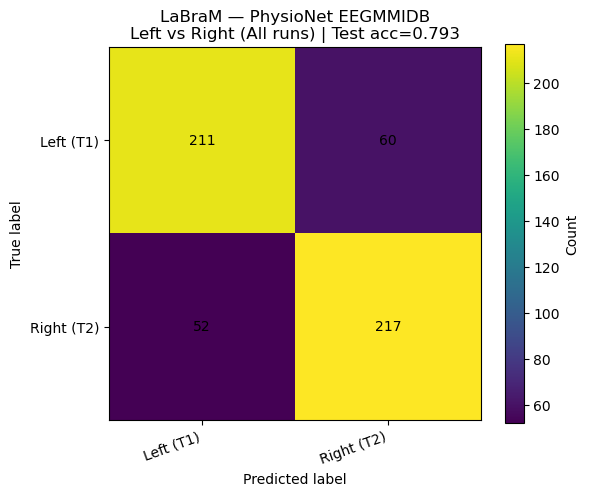

In [12]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

BEST_PATH = OUT_DIR / "best.pth"
print("Loading best checkpoint:", BEST_PATH)

ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        x = batch["inputs"].to(device, non_blocking=True)
        y = batch["labels"].to(device, non_blocking=True)

        logits = model(x, input_chans=input_chans.to(device))
        preds = logits.argmax(dim=1)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_acc = float((all_preds == all_labels).mean())
print(f"TEST acc: {test_acc:.4f}  (n={len(all_labels)})")

# Confusion matrix: rows=true, cols=pred
cm = np.zeros((2, 2), dtype=int)
for t, p in zip(all_labels, all_preds):
    cm[int(t), int(p)] += 1

class_names = ["Left (T1)", "Right (T2)"]

print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Per-class acc
for cls in [0, 1]:
    mask = (all_labels == cls)
    acc_cls = float((all_preds[mask] == cls).mean()) if mask.any() else float("nan")
    print(f"class {cls} ({class_names[cls]}) acc: {acc_cls:.4f}  (n={int(mask.sum())})")

# --- Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)

ax.set_title(f"LaBraM — PhysioNet EEGMMIDB\nLeft vs Right (All runs) | Test acc={test_acc:.3f}")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

ax.set_xticks([0, 1], labels=class_names, rotation=20, ha="right")
ax.set_yticks([0, 1], labels=class_names)

# Annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Count")

plt.tight_layout()
plt.show()